In [2]:
import pandas as pd
from pandas_datareader import data
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from utils import load_financial_data, plot_ts, plot_multi_ts, sharpe_ratio, rate_of_return
import FinanceDataReader as fdr 

In [2]:
from markov import MarkovStrategy, markov_train, markov_test, markov_benchmark

In [7]:
def find_tickers_sp500(sector):
    df_sp500 = fdr.StockListing('S&P500') # list of stocks in S&P500
    tickers = list(df_sp500[df_sp500['Sector']==sector]['Symbol']) # Filter those in the sector
    return tickers # Return the tickers

In [1]:
def find_tickers_dj30(sector):
    df_sp500 = fdr.StockListing('DJI') # list of stocks in S&P500
    tickers = list(df_sp500[df_sp500['Sector']==sector]['Symbol']) # Filter those in the sector
    return tickers # Return the tickers

In [6]:
# check S&P 500 stocks
df_sp500 = fdr.StockListing('S&P500')
print(df_sp500)
print(list(df_sp500['Sector'].unique()))

    Symbol                Name                  Sector  \
0      MMM                  3M             Industrials   
1      AOS         A. O. Smith             Industrials   
2      ABT              Abbott             Health Care   
3     ABBV              AbbVie             Health Care   
4      ACN           Accenture  Information Technology   
..     ...                 ...                     ...   
498    XYL          Xylem Inc.             Industrials   
499    YUM         Yum! Brands  Consumer Discretionary   
500   ZBRA  Zebra Technologies  Information Technology   
501    ZBH       Zimmer Biomet             Health Care   
502    ZTS              Zoetis             Health Care   

                                         Industry  
0                        Industrial Conglomerates  
1                               Building Products  
2                           Health Care Equipment  
3                                   Biotechnology  
4                  IT Consulting & Other Se

In [8]:
print(find_tickers_sp500("Information Technology"))

['ACN', 'ADBE', 'AMD', 'AKAM', 'APH', 'ADI', 'ANSS', 'AAPL', 'AMAT', 'ANET', 'ADSK', 'AVGO', 'CDNS', 'CDW', 'CSCO', 'CTSH', 'GLW', 'ENPH', 'EPAM', 'FFIV', 'FICO', 'FSLR', 'FTNT', 'IT', 'GEN', 'HPE', 'HPQ', 'IBM', 'INTC', 'INTU', 'JBL', 'JNPR', 'KEYS', 'KLAC', 'LRCX', 'MCHP', 'MU', 'MSFT', 'MPWR', 'MSI', 'NTAP', 'NVDA', 'NXPI', 'ON', 'ORCL', 'PANW', 'PTC', 'QRVO', 'QCOM', 'ROP', 'CRM', 'STX', 'NOW', 'SWKS', 'SMCI', 'SNPS', 'TEL', 'TDY', 'TER', 'TXN', 'TRMB', 'TYL', 'VRSN', 'WDC', 'ZBRA']


In [12]:
print("tickers=(", end='')
for tic in find_tickers_sp500("Information Technology"):
    print(f"\"{tic}\" ", end='')
print(")")

tickers=("ACN" "ADBE" "AMD" "AKAM" "APH" "ADI" "ANSS" "AAPL" "AMAT" "ANET" "ADSK" "AVGO" "CDNS" "CDW" "CSCO" "CTSH" "GLW" "ENPH" "EPAM" "FFIV" "FICO" "FSLR" "FTNT" "IT" "GEN" "HPE" "HPQ" "IBM" "INTC" "INTU" "JBL" "JNPR" "KEYS" "KLAC" "LRCX" "MCHP" "MU" "MSFT" "MPWR" "MSI" "NTAP" "NVDA" "NXPI" "ON" "ORCL" "PANW" "PTC" "QRVO" "QCOM" "ROP" "CRM" "STX" "NOW" "SWKS" "SMCI" "SNPS" "TEL" "TDY" "TER" "TXN" "TRMB" "TYL" "VRSN" "WDC" "ZBRA" )


In [16]:
def backtest(sector,
             threshold_to_buy,
             threshold_to_sell,
             lookback):
    tickers = find_tickers_sp500(sector)

    strategy_performances = []
    for ticker in tickers:
        perf = markov_benchmark(
            ticker=ticker,
            train_start_date='2010-01-01',
            train_end_date='2022-12-31',
            test_start_date='2023-01-01',
            test_end_date='2023-12-31',
            threshold_to_buy=threshold_to_buy,
            threshold_to_sell=threshold_to_sell,
            lookback=lookback,
            initial_cash=1000,
            num_share_per_trade=1,
        )

        strategy_performances.append({
            "strategy": perf["wealth"].pct_change(),
            "buy and hold": perf["price"].pct_change(),
        })

    results = []

    results.append(f".{'':=^8}.{'':=^15}.{'':=^8}.{'':=^8}.{'':=^8}.")
    results.append(f"|{'Ticker':^8}|{'Metric':^15}|{'Markov':^8}|{'Stock':^8}|{'Better':^8}|")
    results.append(f"|{'':=^8}|{'':=^15}|{'':=^8}|{'':=^8}|{'':=^8}|")
    num_better = 0
    for i in range(len(tickers)):
        strat = strategy_performances[i]["strategy"]
        stock = strategy_performances[i]["buy and hold"]

        strat_sharpe = sharpe_ratio(strat)
        stock_sharpe = sharpe_ratio(stock)
        is_better = strat_sharpe > stock_sharpe

        num_better += is_better

        results.append(f"|{'':^8}|{'Sharpe ratio':^15}|{strat_sharpe:^8.3f}|{stock_sharpe:^8.3f}|{'':^8}|")
        results.append(f"|{tickers[i]:^8}|{'Expected return':^15}|{strat.mean():^8.3f}|{stock.mean():^8.3f}|{is_better:^8}|")
        results.append(f"|{'':^8}|{'Volatility':^15}|{strat.std():^8.3f}|{stock.std():^8.3f}|{'':^8}|")
        results.append(f"|{'':_^8}|{'':_^15}|{'':_^8}|{'':_^8}|{'':_^8}|")

    results.append(f"|{'':=^8}|{'':=^15}|{'':=^8}|{'':=^8}|{'':=^8}|")

    results.append(f"The number of better cases: {num_better}")

    return "\n".join(results)

In [17]:
def save_txt(data, file_path):
    with open(file_path, "w") as f:
        f.write(data)

## Backtest against IT stocks

In [18]:
results = backtest(
    sector="Information Technology",
    threshold_to_buy=1,
    threshold_to_sell=1,
    lookback=3,
)
save_txt(results, "./results/IT_3_1_1.md")

File data found...reading ACN data
File data found...reading ACN data
File data found...reading ADBE data
File data found...reading ADBE data
File data found...reading AMD data
File data found...reading AMD data
File data found...reading AKAM data
File data found...reading AKAM data
File data found...reading APH data
File data found...reading APH data
File data found...reading ADI data
File data found...reading ADI data
File data found...reading ANSS data
File data found...reading ANSS data
File data found...reading AAPL data
File data found...reading AAPL data
File data found...reading AMAT data
File data found...reading AMAT data
File data found...reading ANET data
File data found...reading ANET data
File data found...reading ADSK data
File data found...reading ADSK data
File data found...reading AVGO data
File data found...reading AVGO data
File data found...reading CDNS data
File data found...reading CDNS data
File data found...reading CDW data
File data found...reading CDW data
Fi

In [19]:
results = backtest(
    sector="Information Technology",
    threshold_to_buy=2,
    threshold_to_sell=2,
    lookback=5,
)
save_txt(results, "./results/IT_5_2_2.md")

File data found...reading ACN data
File data found...reading ACN data
File data found...reading ADBE data
File data found...reading ADBE data
File data found...reading AMD data
File data found...reading AMD data
File data found...reading AKAM data
File data found...reading AKAM data
File data found...reading APH data
File data found...reading APH data
File data found...reading ADI data
File data found...reading ADI data
File data found...reading ANSS data
File data found...reading ANSS data
File data found...reading AAPL data
File data found...reading AAPL data
File data found...reading AMAT data
File data found...reading AMAT data
File data found...reading ANET data
File data found...reading ANET data
File data found...reading ADSK data
File data found...reading ADSK data
File data found...reading AVGO data
File data found...reading AVGO data
File data found...reading CDNS data
File data found...reading CDNS data
File data found...reading CDW data
File data found...reading CDW data
Fi

## Backtest against Energy stocks

In [21]:
results = backtest(
    sector="Energy",
    threshold_to_buy=1,
    threshold_to_sell=1,
    lookback=3,
)
save_txt(results, "./results/Energy_3_1_1.md")

File data found...reading APA data
File data found...reading APA data
File data found...reading BKR data
File data found...reading BKR data
File data found...reading CVX data
File data found...reading CVX data
File data found...reading COP data
File data found...reading COP data
File data found...reading CTRA data
File data found...reading CTRA data
File data found...reading DVN data
File data found...reading DVN data
File data found...reading FANG data
File data found...reading FANG data
File data found...reading EOG data
File data found...reading EOG data
File data found...reading EQT data
File data found...reading EQT data
File data found...reading XOM data
File data found...reading XOM data
File data found...reading HAL data
File data found...reading HAL data
File data found...reading HES data
File data found...reading HES data
File data found...reading KMI data
File data found...reading KMI data
File data found...reading MRO data
File data found...reading MRO data
File data found.

In [22]:
results = backtest(
    sector="Energy",
    threshold_to_buy=2,
    threshold_to_sell=2,
    lookback=5,
)
save_txt(results, "./results/Energy_5_2_2.md")

File data found...reading APA data
File data found...reading APA data
File data found...reading BKR data
File data found...reading BKR data
File data found...reading CVX data
File data found...reading CVX data
File data found...reading COP data
File data found...reading COP data
File data found...reading CTRA data
File data found...reading CTRA data
File data found...reading DVN data
File data found...reading DVN data
File data found...reading FANG data
File data found...reading FANG data
File data found...reading EOG data
File data found...reading EOG data
File data found...reading EQT data
File data found...reading EQT data
File data found...reading XOM data
File data found...reading XOM data
File data found...reading HAL data
File data found...reading HAL data
File data found...reading HES data
File data found...reading HES data
File data found...reading KMI data
File data found...reading KMI data
File data found...reading MRO data
File data found...reading MRO data
File data found.

## Backtest against Consumer Staples stocks

In [ ]:
df_sp500['Sector'].unique()

array(['Industrials', 'Health Care', 'Information Technology',
       'Utilities', 'Financials', 'Materials', 'Consumer Discretionary',
       'Real Estate', 'Communication Services', 'Consumer Staples',
       'Energy'], dtype=object)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


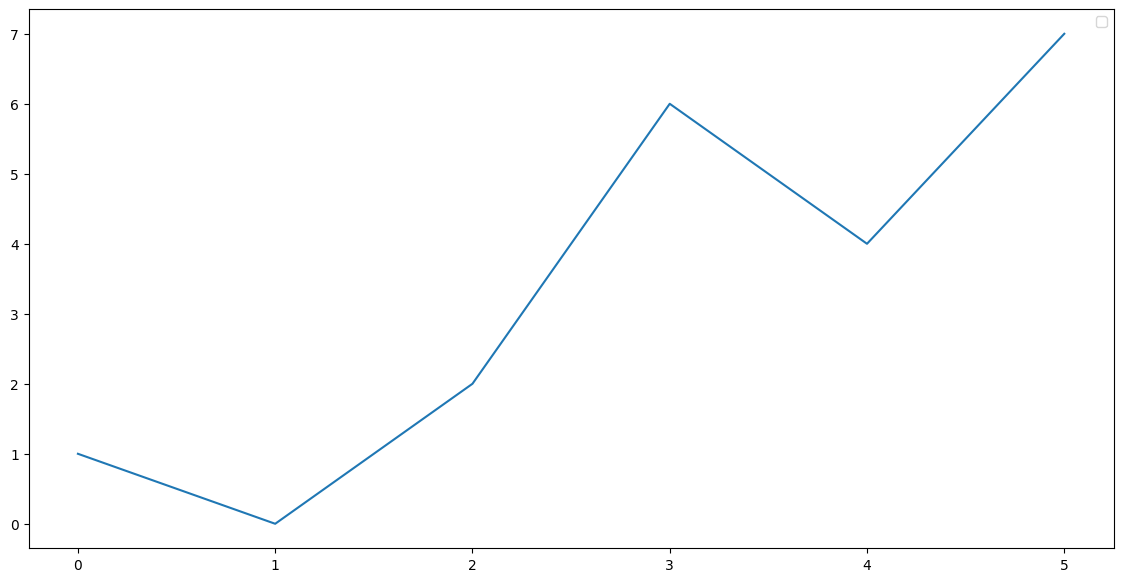

In [30]:
plot_ts([1, 0, 2, 6, 4, 7], title="", label_ts="", x_label="", y_label="")

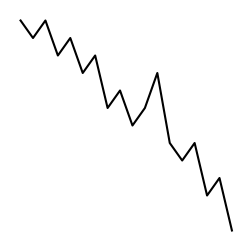

In [60]:
plt.figure(figsize=(3,3))
plt.axis('off')
plt.plot(14 - np.array([2, 3, 2, 4, 3, 5, 4, 7, 6, 8, 7, 5, 9, 10, 9, 12, 11, 14]), c="black")
plt.savefig('demo.png', transparent=True)